
# Example of High Gamma Filter

Below is a code sample for extracting high gamma power from a raw data file, followed by permutation cluster stats on that high gamma power data


### working version 10/19/23

In [ ]:
#### plot filt so we can figure out what base_times to use that don't have outliers or spikes across all channels.
###
import sys
print(sys.path)
sys.path.append("C:/Users/jz421/Desktop/GlobalLocal/IEEG_Pipelines/") #need to do this cuz otherwise ieeg isn't added to path...

from ieeg.navigate import channel_outlier_marker, trial_ieeg, crop_empty_data, \
    outliers_to_nan
from ieeg.io import raw_from_layout, get_data
from ieeg.timefreq.utils import crop_pad
from ieeg.timefreq import gamma
from ieeg.calc.scaling import rescale
import mne
import os
import numpy as np
from ieeg.calc.reshape import make_data_same
from ieeg.calc.stats import time_perm_cluster

from misc_functions import calculate_RTs, save_channels_to_file, save_sig_chans
import matplotlib.pyplot as plt

sub = 'D0063'
task = 'GlobalLocal'
LAB_root = None
channels = None
full_trial_base = False

if LAB_root is None:
    HOME = os.path.expanduser("~")
    if os.name == 'nt':  # windows
        LAB_root = os.path.join(HOME, "Box", "CoganLab")
    else:  # mac
        LAB_root = os.path.join(HOME, "Library", "CloudStorage", "Box-Box",
                                "CoganLab")

layout = get_data(task, root=LAB_root)
filt = raw_from_layout(layout.derivatives['derivatives/clean'], subject=sub,
                       extension='.edf', desc='clean', preload=False)

filt.plot()

In [ ]:
###
import sys
print(sys.path)
sys.path.append("C:/Users/jz421/Desktop/GlobalLocal/IEEG_Pipelines/") #need to do this cuz otherwise ieeg isn't added to path...

from ieeg.navigate import channel_outlier_marker, trial_ieeg, crop_empty_data, \
    outliers_to_nan
from ieeg.io import raw_from_layout, get_data
from ieeg.timefreq.utils import crop_pad
from ieeg.timefreq import gamma
from ieeg.calc.scaling import rescale
import mne
import os
import numpy as np
from ieeg.calc.reshape import make_data_same
from ieeg.calc.stats import time_perm_cluster

from misc_functions import calculate_RTs, save_channels_to_file, save_sig_chans
import matplotlib.pyplot as plt


def get_baseline(inst: mne.io.BaseRaw, base_times_list: list[tuple[float, float]]):
    all_data = []
    all_events = []
    
    inst = inst.copy()
    inst.load_data()
    ch_type = inst.get_channel_types(only_data_chs=True)[0]
    inst.set_eeg_reference(ref_channels="average", ch_type=ch_type)
    
    last_sample = 0
    for base_times in base_times_list:
        adjusted_base_times = [base_times[0] - 0.5, base_times[1] + 0.5]
        trials = trial_ieeg(inst, "experimentStart", adjusted_base_times, preload=True)
        
        if trials is None or len(trials) == 0:
            print(f"Warning: No trials found for base_times {base_times}. Skipping...")
            continue
        
        all_data.append(trials.get_data())
        all_events.extend([[last_sample + i, 0, 1] for i in range(len(trials))])
        last_sample += len(trials)
    
    combined_data = np.concatenate(all_data, axis=0)
    combined_trials = mne.EpochsArray(combined_data, inst.info, events=np.array(all_events), tmin=trials.tmin)
    
    HG_base = gamma.extract(combined_trials, copy=True, n_jobs=1)
    # broadband_base = gamma.extract(combined_trials, copy=True, n_jobs=1, passband=(0,1000))
    crop_pad(HG_base, "0.5s")
    # crop_pad(broadband_base, "0.5s")
    
    del inst
    return HG_base




def plot_HG_and_stats(sub, task, output_name, event=None, times=(-1, 1.5),
                      base_times=(-0.5, 0), LAB_root=None, channels=None,
                      full_trial_base=False):
    """
    Plot high gamma (HG) and statistics for a given subject and task using specified event.

    Parameters:
    - sub (str): The subject identifier.
    - task (str): The task identifier.
    - output_name (str): The name for the output files.
    - event (str, optional): Event name to process. Defaults to None.
    - times (tuple, optional): A tuple indicating the start and end times for processing. Defaults to (-1, 1.5).
    - base_times (tuple, optional): A tuple indicating the start and end base times for processing. Defaults to (-0.5, 0).
    - LAB_root (str, optional): The root directory for the lab. Will be determined based on OS if not provided. Defaults to None.
    - channels (list of strings, optional): The channels to plot and get stats for. Default is all channels.
    - full_trial_base (boolean): Whether to use the full trial as the baseline period. Default is False.
    This function will process the provided event for a given subject and task.
    High gamma (HG) will be computed, and statistics will be calculated and plotted.
    The results will be saved to output files.
    """
    pass


sub = 'D0063'
task = 'GlobalLocal'
output_name = "driftTest_Stimulus_experimentStartBase_30to90sec"
events = ["Stimulus"]
times = (-1,1.5)
base_times = [(30,90)]
LAB_root = None
channels = None
full_trial_base = False

if LAB_root is None:
    HOME = os.path.expanduser("~")
    if os.name == 'nt':  # windows
        LAB_root = os.path.join(HOME, "Box", "CoganLab")
    else:  # mac
        LAB_root = os.path.join(HOME, "Library", "CloudStorage", "Box-Box",
                                "CoganLab")

layout = get_data(task, root=LAB_root)
filt = raw_from_layout(layout.derivatives['derivatives/clean'], subject=sub,
                       extension='.edf', desc='clean', preload=False)
save_dir = os.path.join(layout.root, 'derivatives', 'freqFilt', 'figs', sub)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

good = crop_empty_data(filt)
# %%

print(f"good channels before dropping bads: {len(good.ch_names)}")
print(f"filt channels before dropping bads: {len(filt.ch_names)}")

good.info['bads'] = channel_outlier_marker(good, 3, 2)
print("Bad channels in 'good':", good.info['bads'])

filt.drop_channels(good.info['bads'])  # this has to come first cuz if you drop from good first, then good.info['bads'] is just empty
good.drop_channels(good.info['bads'])

print("Bad channels in 'good' after dropping once:", good.info['bads'])

print(f"good channels after dropping bads: {len(good.ch_names)}")
print(f"filt channels after dropping bads: {len(filt.ch_names)}")

HG_base = get_baseline(filt, base_times)
good.load_data()

# If channels is None, use all channels
if channels is None:
    channels = good.ch_names
else:
    # Validate the provided channels
    invalid_channels = [ch for ch in channels if ch not in good.ch_names]
    if invalid_channels:
        raise ValueError(
            f"The following channels are not valid: {invalid_channels}")

    # Use only the specified channels
    good.pick_channels(channels)

ch_type = filt.get_channel_types(only_data_chs=True)[0]
good.set_eeg_reference(ref_channels="average", ch_type=ch_type)


all_epochs_list = []

for event in events:
# Epoching and HG extraction for each specified event. Then concatenate all trials epochs objects together (do Stimulus/c25 and Stimulus/c75 for example, and combine to get all congruent trials)
    times_adj = [times[0] - 0.5, times[1] + 0.5]
    trials = trial_ieeg(good, event, times_adj, preload=True,
                        reject_by_annotation=False)
    all_epochs_list.append(trials)

# Concatenate all trials
all_trials = mne.concatenate_epochs(all_epochs_list)

outliers_to_nan(all_trials, outliers=10)
HG_ev1 = gamma.extract(all_trials, copy=True, n_jobs=1)
# broadband_ev1 = gamma.extract(all_trials, copy=True, n_jobs=1, passband=(0,1000))
print("HG_ev1 before crop_pad: ", HG_ev1.tmin, HG_ev1.tmax)
crop_pad(HG_ev1, "0.5s")
print("HG_ev1 after crop_pad: ", HG_ev1.tmin, HG_ev1.tmax)

# crop_pad(broadband_ev1, "0.5s")
HG_ev1_rescaled = rescale(HG_ev1, HG_base, copy=True, mode='zscore')
# broadband_ev1_rescaled = rescale(broadband_ev1, broadband_base, copy=True, mode='zscore')
# HG_ev1_rescaled_fixationCross = rescale(HG_ev1, HG_base_fixationCross, copy=True, mode='zscore')

HG_base.decimate(2)
HG_ev1.decimate(2)

# broadband_base.decimate(2)
# broadband_ev1.decimate(2)

# HG_base_fixationCross.decimate(2)


HG_ev1_avgOverTime = np.nanmean(HG_ev1.get_data(), axis=2)
HG_ev1_rescaled_avgOverTime = np.nanmean(HG_ev1_rescaled.get_data(), axis=2)


HG_ev1_evoke = HG_ev1.average(method=lambda x: np.nanmean(x, axis=0)) #axis=0 should be set for actually running this, the axis=2 is just for drift testing.
HG_ev1_evoke_rescaled = HG_ev1_rescaled.average(method=lambda x: np.nanmean(x, axis=0))

if event == "Stimulus":
    print('plotting stimulus')
    fig = HG_ev1_evoke_rescaled.plot(unit=False, scalings=dict(sEEG=1)) #this line is not finishing...
    print('plotted')
    # for ax in fig.axes:
    #     ax.axvline(x=avg_RT, color='r', linestyle='--')
    print('about to save')
    fig.savefig(save_dir + '_HG_ev1_Stimulus_zscore.png')
    print('saved')
else:
    print('about to plot if not stimulus')
    fig = HG_ev1_evoke_rescaled.plot(unit=False, scalings=dict(sEEG=1))
    print('plotted non stimulus')
    fig.savefig(save_dir + f'_HG_ev1_{output_name}_zscore.png')

###
print(f"Shape of HG_ev1._data: {HG_ev1._data.shape}")
print(f"Shape of HG_base._data: {HG_base._data.shape}")

sig1 = HG_ev1._data
sig2 = HG_base._data
sig2 = make_data_same(sig2, sig1.shape)
print(f"Shape of sig1: {sig1.shape}")
print(f"Shape of sig2: {sig2.shape}")

mat = time_perm_cluster(sig1, sig2, 0.05, n_jobs=6, ignore_adjacency=1)
fig = plt.figure()
plt.imshow(mat, aspect='auto')
fig.savefig(save_dir + f'_{output_name}_stats.png', dpi=300)

channels = good.ch_names

#save channels with their indices 
save_channels_to_file(channels, sub, task, save_dir)

# save significant channels to a json
save_sig_chans(f'{output_name}', mat, channels, sub, save_dir)


### do fixation cross baseline but just 0.2 seconds before stim onset

In [ ]:
###
import sys
print(sys.path)
sys.path.append("C:/Users/jz421/Desktop/GlobalLocal/IEEG_Pipelines/") #need to do this cuz otherwise ieeg isn't added to path...

from ieeg.navigate import channel_outlier_marker, trial_ieeg, crop_empty_data, \
    outliers_to_nan
from ieeg.io import raw_from_layout, get_data
from ieeg.timefreq.utils import crop_pad
from ieeg.timefreq import gamma
from ieeg.calc.scaling import rescale
import mne
import os
import numpy as np
from ieeg.calc.reshape import make_data_same
from ieeg.calc.stats import time_perm_cluster

from misc_functions import calculate_RTs, save_channels_to_file, save_sig_chans, load_sig_chans
import matplotlib.pyplot as plt


def plot_HG_and_stats(sub, task, output_name, event=None, times=(-1, 1.5),
                      base_times=(-0.5, 0), LAB_root=None, channels=None,
                      full_trial_base=False):
    """
    Plot high gamma (HG) and statistics for a given subject and task using specified event.

    Parameters:
    - sub (str): The subject identifier.
    - task (str): The task identifier.
    - output_name (str): The name for the output files.
    - event (str, optional): Event name to process. Defaults to None.
    - times (tuple, optional): A tuple indicating the start and end times for processing. Defaults to (-1, 1.5).
    - base_times (tuple, optional): A tuple indicating the start and end base times for processing. Defaults to (-0.5, 0).
    - LAB_root (str, optional): The root directory for the lab. Will be determined based on OS if not provided. Defaults to None.
    - channels (list of strings, optional): The channels to plot and get stats for. Default is all channels.
    - full_trial_base (boolean): Whether to use the full trial as the baseline period. Default is False.
    This function will process the provided event for a given subject and task.
    High gamma (HG) will be computed, and statistics will be calculated and plotted.
    The results will be saved to output files.
    """
    pass
subjects = ["D0059", "D0063", "D0065", "D0069", "D0071"]

for sub in subjects:
# sub = 'D0057'
    task = 'GlobalLocal'
    output_name = "Stimulus_fixationCrossBase_1sec"
    events = ["Stimulus"]
    times = (-1,1.5)
    base_times = [-1,0]
    LAB_root = None
    channels = None
    full_trial_base = False

    if LAB_root is None:
        HOME = os.path.expanduser("~")
        if os.name == 'nt':  # windows
            LAB_root = os.path.join(HOME, "Box", "CoganLab")
        else:  # mac
            LAB_root = os.path.join(HOME, "Library", "CloudStorage", "Box-Box",
                                    "CoganLab")

    layout = get_data(task, root=LAB_root)
    filt = raw_from_layout(layout.derivatives['derivatives/clean'], subject=sub,
                        extension='.edf', desc='clean', preload=False)
    save_dir = os.path.join(layout.root, 'derivatives', 'freqFilt', 'figs', sub)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    good = crop_empty_data(filt)
    # %%

    print(f"good channels before dropping bads: {len(good.ch_names)}")
    print(f"filt channels before dropping bads: {len(filt.ch_names)}")

    good.info['bads'] = channel_outlier_marker(good, 3, 2)
    print("Bad channels in 'good':", good.info['bads'])

    filt.drop_channels(good.info['bads'])  # this has to come first cuz if you drop from good first, then good.info['bads'] is just empty
    good.drop_channels(good.info['bads'])

    print("Bad channels in 'good' after dropping once:", good.info['bads'])

    print(f"good channels after dropping bads: {len(good.ch_names)}")
    print(f"filt channels after dropping bads: {len(filt.ch_names)}")

    good.load_data()

    # If channels is None, use all channels
    if channels is None:
        channels = good.ch_names
    else:
        # Validate the provided channels
        invalid_channels = [ch for ch in channels if ch not in good.ch_names]
        if invalid_channels:
            raise ValueError(
                f"The following channels are not valid: {invalid_channels}")

        # Use only the specified channels
        good.pick_channels(channels)

    ch_type = filt.get_channel_types(only_data_chs=True)[0]
    good.set_eeg_reference(ref_channels="average", ch_type=ch_type)

    # Create a baseline EpochsTFR using the stimulus event

    adjusted_base_times = [base_times[0] - 0.5, base_times[1] + 0.5]
    trials = trial_ieeg(good, "Stimulus", adjusted_base_times, preload=True)
    outliers_to_nan(trials, outliers=10)
    HG_base = gamma.extract(trials, copy=False, n_jobs=1)
    crop_pad(HG_base, "0.5s")

    all_epochs_list = []

    for event in events:
    # Epoching and HG extraction for each specified event. Then concatenate all trials epochs objects together (do Stimulus/c25 and Stimulus/c75 for example, and combine to get all congruent trials)
        times_adj = [times[0] - 0.5, times[1] + 0.5]
        trials = trial_ieeg(good, event, times_adj, preload=True,
                            reject_by_annotation=False)
        all_epochs_list.append(trials)

    # Concatenate all trials
    all_trials = mne.concatenate_epochs(all_epochs_list)

    outliers_to_nan(all_trials, outliers=10)
    HG_ev1 = gamma.extract(all_trials, copy=True, n_jobs=1)
    print("HG_ev1 before crop_pad: ", HG_ev1.tmin, HG_ev1.tmax)
    crop_pad(HG_ev1, "0.5s")
    print("HG_ev1 after crop_pad: ", HG_ev1.tmin, HG_ev1.tmax)


    HG_ev1_rescaled = rescale(HG_ev1, HG_base, copy=True, mode='zscore')

    HG_base.decimate(2)
    HG_ev1.decimate(2)


    HG_ev1_avgOverTime = np.nanmean(HG_ev1.get_data(), axis=2)
    HG_ev1_rescaled_avgOverTime = np.nanmean(HG_ev1_rescaled.get_data(), axis=2)

    HG_ev1_evoke = HG_ev1.average(method=lambda x: np.nanmean(x, axis=0)) #axis=0 should be set for actually running this, the axis=2 is just for drift testing.
    HG_ev1_evoke_rescaled = HG_ev1_rescaled.average(method=lambda x: np.nanmean(x, axis=0))

    if event == "Stimulus":
        print('plotting stimulus')
        fig = HG_ev1_evoke_rescaled.plot(unit=False, scalings=dict(sEEG=1)) #this line is not finishing...
        print('plotted')
        # for ax in fig.axes:
        #     ax.axvline(x=avg_RT, color='r', linestyle='--')
        print('about to save')
        fig.savefig(save_dir + '_HG_ev1_Stimulus_zscore.png')
        print('saved')
    else:
        print('about to plot if not stimulus')
        fig = HG_ev1_evoke_rescaled.plot(unit=False, scalings=dict(sEEG=1))
        print('plotted non stimulus')
        fig.savefig(save_dir + f'_HG_ev1_{output_name}_zscore.png')

    ###
    print(f"Shape of HG_ev1._data: {HG_ev1._data.shape}")
    print(f"Shape of HG_base._data: {HG_base._data.shape}")

    sig1 = HG_ev1._data
    sig2 = HG_base._data
    sig2 = make_data_same(sig2, sig1.shape)
    print(f"Shape of sig1: {sig1.shape}")
    print(f"Shape of sig2: {sig2.shape}")

    mat = time_perm_cluster(sig1, sig2, 0.05, n_jobs=6, ignore_adjacency=1)
    fig = plt.figure()
    plt.imshow(mat, aspect='auto')
    fig.savefig(save_dir + f'_{output_name}_stats.png', dpi=300)

    channels = good.ch_names

    #save channels with their indices 
    save_channels_to_file(channels, sub, task, save_dir)

    # save significant channels to a json
    save_sig_chans(f'{output_name}', mat, channels, sub, save_dir)


    base_path = r'C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs'
    stim_filename = f'{base_path}\\{sub}\\sig_chans_{sub}_Stimulus_fixationCrossBase_1sec.json'
    stim_sig_chans = load_sig_chans(stim_filename)

    fig = HG_ev1_evoke_rescaled.plot(unit=False, scalings=dict(sEEG=1), picks=stim_sig_chans) #this line is not finishing...

    fig.savefig(save_dir + '_HG_ev1_Stimulus_fixationCrossBase_1sec_zscore_sigChans.png')


### try gregs suggestion of using make_data_same to destroy the fixation cross

['c:\\Users\\jz421\\Desktop\\GlobalLocal', 'C:\\Users\\jz421\\Desktop\\GlobalLocal\\IEEG_Pipelines', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\python311.zip', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\DLLs', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg', '', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32\\lib', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages\\Pythonwin', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib\\site-packages', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib\\site-packages\\win32', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\L

c:\Users\jz421\AppData\Local\anaconda3\envs\ieeg\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-01_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-01_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-01_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-02_desc-clean_ieeg.edf...
EDF file detected
Setting channel info str

C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 226 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


good channels before dropping bads: 178
filt channels before dropping bads: 178
outlier round 1 channels: ['RAMT8']
outlier round 2 channels: ['RAMT8', 'RPI16']
outlier round 2 channels: ['RAMT8', 'RPI16', 'LAMT12']
Bad channels in 'good': ['RAMT8', 'RPI16', 'LAMT12']
Bad channels in 'good' after dropping once: []
good channels after dropping bads: 175
filt channels after dropping bads: 175
Reading 0 ... 5983997  =      0.000 ...  2921.874 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n25', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus

100%|██████████| 448/448 [06:06<00:00,  1.22it/s]


Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n25', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/n75', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/n25', 'Stimulus/i75/n75', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75', 'experimentStart']
Not setting metadata
448 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 448 events and 7169 original

C:\Users\jz421\AppData\Local\Temp\ipykernel_20368\3142499754.py:125: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_trials = mne.concatenate_epochs(all_epochs_list)


Not setting metadata
448 matching events found
No baseline correction applied


100%|██████████| 448/448 [09:06<00:00,  1.22s/it]


HG_ev1 before crop_pad:  -1.5 2.0
HG_ev1 after crop_pad:  -1.0 1.5
Applying baseline correction (mode: zscore)


C:\Users\jz421\AppData\Local\Temp\ipykernel_20368\3142499754.py:135: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_base.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_20368\3142499754.py:136: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_ev1.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_20368\3142499754.py:138: RuntimeWarning: Mean of empty slice
  HG_ev1_avgOverTime = np.nanmean(HG_ev1.get_data(), axis=2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_20368\3142499754.py:139: RuntimeWarning: Mean of empty slice
  HG_ev1_rescaled_avgOverTime = np.nanmean(HG_ev1_rescaled.get_data(), axis=2)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
plotting stimulus


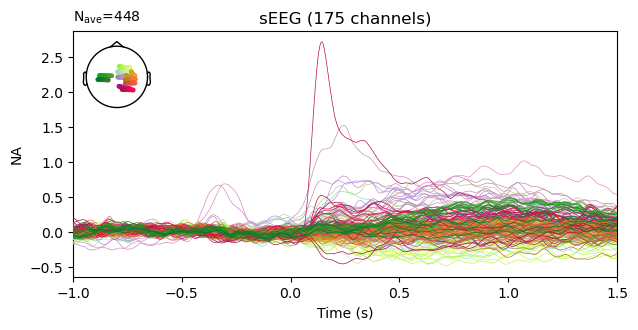

plotted
about to save
saved
Shape of HG_ev1._data: (448, 175, 2561)
Shape of HG_base._data: (448, 175, 1025)
Shape of sig1: (448, 175, 2561)
Shape of sig2: (448, 175, 1025)
Shape of sig3: (448, 175, 1026)
Shape of sig4: (448, 175, 1025)
Shape of sig5: (448, 175, 2561)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   58.5s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   59.0s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   59.0s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   59.2s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   59.4s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   59.5s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:  2.9min
[Parallel(

Loaded significant channels for subject D0057


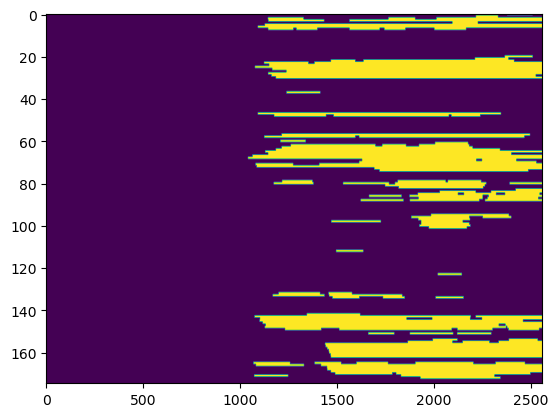

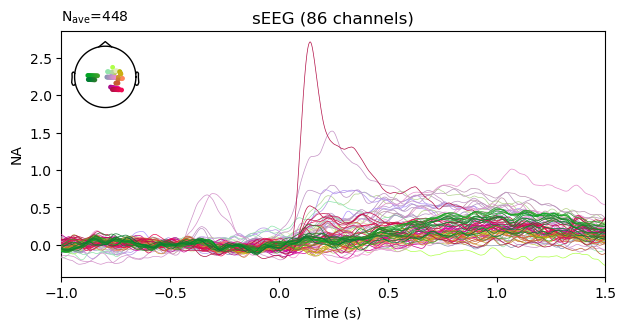

In [6]:
###
import sys
print(sys.path)
sys.path.append("C:/Users/jz421/Desktop/GlobalLocal/IEEG_Pipelines/") #need to do this cuz otherwise ieeg isn't added to path...

from ieeg.navigate import channel_outlier_marker, trial_ieeg, crop_empty_data, \
    outliers_to_nan
from ieeg.io import raw_from_layout, get_data
from ieeg.timefreq.utils import crop_pad
from ieeg.timefreq import gamma
from ieeg.calc.scaling import rescale
import mne
import os
import numpy as np
from ieeg.calc.reshape import make_data_same
from ieeg.calc.stats import time_perm_cluster

from misc_functions import calculate_RTs, save_channels_to_file, save_sig_chans, load_sig_chans
import matplotlib.pyplot as plt


def plot_HG_and_stats(sub, task, output_name, event=None, times=(-1, 1.5),
                      base_times=(-0.5, 0), LAB_root=None, channels=None,
                      full_trial_base=False):
    """
    Plot high gamma (HG) and statistics for a given subject and task using specified event.

    Parameters:
    - sub (str): The subject identifier.
    - task (str): The task identifier.
    - output_name (str): The name for the output files.
    - event (str, optional): Event name to process. Defaults to None.
    - times (tuple, optional): A tuple indicating the start and end times for processing. Defaults to (-1, 1.5).
    - base_times (tuple, optional): A tuple indicating the start and end base times for processing. Defaults to (-0.5, 0).
    - LAB_root (str, optional): The root directory for the lab. Will be determined based on OS if not provided. Defaults to None.
    - channels (list of strings, optional): The channels to plot and get stats for. Default is all channels.
    - full_trial_base (boolean): Whether to use the full trial as the baseline period. Default is False.
    This function will process the provided event for a given subject and task.
    High gamma (HG) will be computed, and statistics will be calculated and plotted.
    The results will be saved to output files.
    """
    pass

subjects = ['D0059', 'D0063', 'D0065', 'D0069', 'D0071']

# for sub in subjects:
sub = 'D0057'
task = 'GlobalLocal'
output_name = "Stimulus_fixationCrossBase_1sec_mirror"
events = ["Stimulus"]
times = (-1,1.5)
base_times = [-1,0]
LAB_root = None
channels = None
full_trial_base = False

if LAB_root is None:
    HOME = os.path.expanduser("~")
    if os.name == 'nt':  # windows
        LAB_root = os.path.join(HOME, "Box", "CoganLab")
    else:  # mac
        LAB_root = os.path.join(HOME, "Library", "CloudStorage", "Box-Box",
                                "CoganLab")

layout = get_data(task, root=LAB_root)
filt = raw_from_layout(layout.derivatives['derivatives/clean'], subject=sub,
                    extension='.edf', desc='clean', preload=False)
save_dir = os.path.join(layout.root, 'derivatives', 'freqFilt', 'figs', sub)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

good = crop_empty_data(filt)
# %%

print(f"good channels before dropping bads: {len(good.ch_names)}")
print(f"filt channels before dropping bads: {len(filt.ch_names)}")

good.info['bads'] = channel_outlier_marker(good, 3, 2)
print("Bad channels in 'good':", good.info['bads'])

filt.drop_channels(good.info['bads'])  # this has to come first cuz if you drop from good first, then good.info['bads'] is just empty
good.drop_channels(good.info['bads'])

print("Bad channels in 'good' after dropping once:", good.info['bads'])

print(f"good channels after dropping bads: {len(good.ch_names)}")
print(f"filt channels after dropping bads: {len(filt.ch_names)}")

good.load_data()

# If channels is None, use all channels
if channels is None:
    channels = good.ch_names
else:
    # Validate the provided channels
    invalid_channels = [ch for ch in channels if ch not in good.ch_names]
    if invalid_channels:
        raise ValueError(
            f"The following channels are not valid: {invalid_channels}")

    # Use only the specified channels
    good.pick_channels(channels)

ch_type = filt.get_channel_types(only_data_chs=True)[0]
good.set_eeg_reference(ref_channels="average", ch_type=ch_type)

# Create a baseline EpochsTFR using the stimulus event

adjusted_base_times = [base_times[0] - 0.5, base_times[1] + 0.5]
trials = trial_ieeg(good, "Stimulus", adjusted_base_times, preload=True)
outliers_to_nan(trials, outliers=10)
HG_base = gamma.extract(trials, copy=False, n_jobs=1)
crop_pad(HG_base, "0.5s")

all_epochs_list = []

for event in events:
# Epoching and HG extraction for each specified event. Then concatenate all trials epochs objects together (do Stimulus/c25 and Stimulus/c75 for example, and combine to get all congruent trials)
    times_adj = [times[0] - 0.5, times[1] + 0.5]
    trials = trial_ieeg(good, event, times_adj, preload=True,
                        reject_by_annotation=False)
    all_epochs_list.append(trials)

# Concatenate all trials
all_trials = mne.concatenate_epochs(all_epochs_list)

outliers_to_nan(all_trials, outliers=10)
HG_ev1 = gamma.extract(all_trials, copy=True, n_jobs=1)
print("HG_ev1 before crop_pad: ", HG_ev1.tmin, HG_ev1.tmax)
crop_pad(HG_ev1, "0.5s")
print("HG_ev1 after crop_pad: ", HG_ev1.tmin, HG_ev1.tmax)

HG_ev1_rescaled = rescale(HG_ev1, HG_base, copy=True, mode='zscore')

HG_base.decimate(2)
HG_ev1.decimate(2)

HG_ev1_avgOverTime = np.nanmean(HG_ev1.get_data(), axis=2)
HG_ev1_rescaled_avgOverTime = np.nanmean(HG_ev1_rescaled.get_data(), axis=2)

HG_ev1_evoke = HG_ev1.average(method=lambda x: np.nanmean(x, axis=0)) #axis=0 should be set for actually running this, the axis=2 is just for drift testing.
HG_ev1_evoke_rescaled = HG_ev1_rescaled.average(method=lambda x: np.nanmean(x, axis=0))

if event == "Stimulus":
    print('plotting stimulus')
    fig = HG_ev1_evoke_rescaled.plot(unit=False, scalings=dict(sEEG=1)) #this line is not finishing...
    print('plotted')
    # for ax in fig.axes:
    #     ax.axvline(x=avg_RT, color='r', linestyle='--')
    print('about to save')
    # fig.savefig(save_dir + '_HG_ev1_Stimulus_zscore.png')
    print('saved')
else:
    print('about to plot if not stimulus')
    fig = HG_ev1_evoke_rescaled.plot(unit=False, scalings=dict(sEEG=1))
    print('plotted non stimulus')
    # fig.savefig(save_dir + f'_HG_ev1_{output_name}_zscore.png')

###
print(f"Shape of HG_ev1._data: {HG_ev1._data.shape}")
print(f"Shape of HG_base._data: {HG_base._data.shape}")

sig1 = HG_ev1._data
sig2 = HG_base._data
sig3 = make_data_same(sig2, (sig2.shape[0],sig2.shape[1],sig2.shape[2]+1)) # originally we want to make the baseline the same shape as the signal. We still want to do that, but first, we'll make it bigger to reflect it once, then back to normal to randomly offset it and remove fixation cross effects.
sig4 = make_data_same(sig3, sig2.shape) #here we do the random offset, we know that sig3 is bigger than sig1 by 1 in the time dimension so it will get randomly sliced.
sig5 = make_data_same(sig4, sig1.shape) #and now sig4 should be sig2 but with a random offset, and we can then set it equal to sig1's shape like the original plan.
print(f"Shape of sig1: {sig1.shape}")
print(f"Shape of sig2: {sig2.shape}")
print(f"Shape of sig3: {sig3.shape}")
print(f"Shape of sig4: {sig4.shape}")
print(f"Shape of sig5: {sig5.shape}")

sig2 = sig5

mat = time_perm_cluster(sig1, sig2, 0.05, n_jobs=6, ignore_adjacency=1)
fig = plt.figure()
plt.imshow(mat, aspect='auto')
# fig.savefig(save_dir + f'_{output_name}_stats.png', dpi=300)

channels = good.ch_names

#save channels with their indices 
# save_channels_to_file(channels, sub, task, save_dir)

# save significant channels to a json
# save_sig_chans(f'{output_name}', mat, channels, sub, save_dir)


base_path = r'C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs'
stim_filename = f'{base_path}\\{sub}\\sig_chans_{sub}_Stimulus_fixationCrossBase_1sec_mirror.json'
stim_sig_chans = load_sig_chans(stim_filename)

fig = HG_ev1_evoke_rescaled.plot(unit=False, scalings=dict(sEEG=1), picks=stim_sig_chans) #this line is not finishing...

# fig.savefig(save_dir + '_HG_ev1_Stimulus_fixationCrossBase_1sec_mirror_zscore_sigChans.png')


### plot each significant channel with its trace and timepoints of significance

['c:\\Users\\jz421\\Desktop\\GlobalLocal', 'C:\\Users\\jz421\\Desktop\\GlobalLocal\\IEEG_Pipelines', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\python311.zip', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\DLLs', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg', '', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32\\lib', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages\\Pythonwin', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib\\site-packages', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib\\site-packages\\win32', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\L

C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (185) does not match the number of channels in the raw data file (184). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (185) does not match the number of channels in the raw data file (184). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (185) does not match the number of channels in the raw data file (184). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 226 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (185) does not match the number of channels in the raw data file (184). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


good channels before dropping bads: 184
filt channels before dropping bads: 184
outlier round 1 channels: ['LMPF15']
outlier round 2 channels: ['LMPF15', 'LASP3']
outlier round 2 channels: ['LMPF15', 'LASP3', 'LASP5']
outlier round 2 channels: ['LMPF15', 'LASP3', 'LASP5', 'LASP6']
outlier round 2 channels: ['LMPF15', 'LASP3', 'LASP5', 'LASP6', 'LMPT2']
outlier round 2 channels: ['LMPF15', 'LASP3', 'LASP5', 'LASP6', 'LMPT2', 'LPT16']
Bad channels in 'good': ['LMPF15', 'LASP3', 'LASP5', 'LASP6', 'LMPT2', 'LPT16']
Bad channels in 'good' after dropping once: []
good channels after dropping bads: 178
filt channels after dropping bads: 178
Reading 0 ... 6582517  =      0.000 ...  3214.120 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/n25', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/n25', '

100%|██████████| 448/448 [06:37<00:00,  1.13it/s]


Used Annotations descriptions: ['Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/n25', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/n25', 'Response/i25/n75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/n25', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/n25', 'Stimulus/i25/n75', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/n75', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75', 'experimentStart']
Not setting metadata
448 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 448 even

C:\Users\jz421\AppData\Local\Temp\ipykernel_15532\316368277.py:101: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_trials = mne.concatenate_epochs(all_epochs_list)


Not setting metadata
448 matching events found
No baseline correction applied


100%|██████████| 448/448 [09:45<00:00,  1.31s/it]


HG_ev1 before crop_pad:  -1.5 2.0
HG_ev1 after crop_pad:  -1.0 1.5
Applying baseline correction (mode: zscore)


C:\Users\jz421\AppData\Local\Temp\ipykernel_15532\316368277.py:111: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_base.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_15532\316368277.py:112: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_ev1.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_15532\316368277.py:114: RuntimeWarning: Mean of empty slice
  HG_ev1_avgOverTime = np.nanmean(HG_ev1.get_data(), axis=2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_15532\316368277.py:115: RuntimeWarning: Mean of empty slice
  HG_ev1_rescaled_avgOverTime = np.nanmean(HG_ev1_rescaled.get_data(), axis=2)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
plotting stimulus


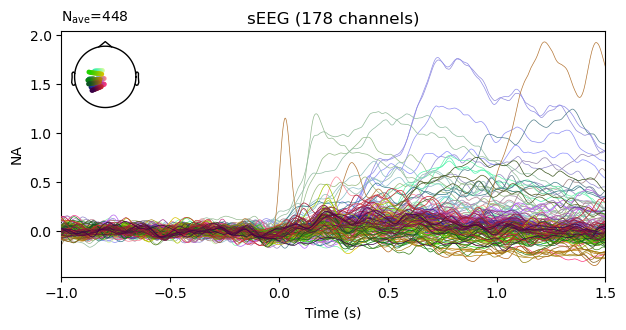

plotted
about to save
saved
Shape of HG_ev1._data: (448, 178, 2561)
Shape of HG_base._data: (448, 178, 1025)
Shape of sig1: (448, 178, 2561)
Shape of sig2: (448, 178, 1025)
Shape of sig3: (448, 178, 1026)
Shape of sig4: (448, 178, 1025)
Shape of sig5: (448, 178, 2561)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:  2.9min
[Parallel(

Saved channel names and indices to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0059\channels_D0059_GlobalLocal.txt
Saved significant channels for subject D0059 and mask Stimulus_fixationCrossBase_1sec_mirror to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0059\sig_chans_D0059_Stimulus_fixationCrossBase_1sec_mirror.json
Loaded significant channels for subject D0059


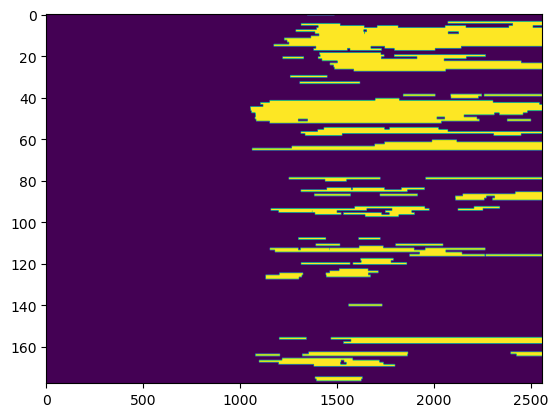

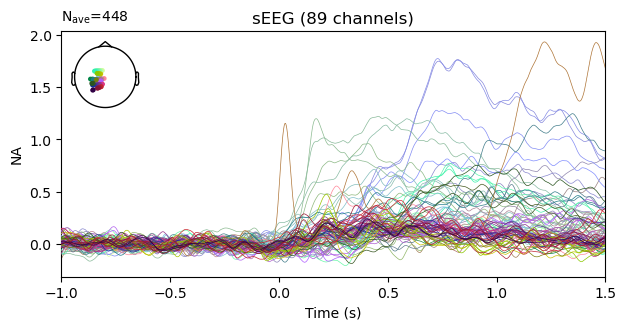

Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-01_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-01_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-01_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-02_desc-clean_ieeg.edf...
EDF file detected
Setting channel info str

C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (241) does not match the number of channels in the raw data file (240). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 227 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (241) does not match the number of channels in the raw data file (240). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (241) does not match the number of channels in the raw data file (240). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 220 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (241) does not match the number of channels in the raw data file (240). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


good channels before dropping bads: 240
filt channels before dropping bads: 240
outlier round 1 channels: ['LOF16']
outlier round 1 channels: ['LOF16', 'RMMT14']
outlier round 2 channels: ['LOF16', 'RMMT14', 'LOF10']
outlier round 2 channels: ['LOF16', 'RMMT14', 'LOF10', 'LOF14']
outlier round 2 channels: ['LOF16', 'RMMT14', 'LOF10', 'LOF14', 'ROF2']
outlier round 2 channels: ['LOF16', 'RMMT14', 'LOF10', 'LOF14', 'ROF2', 'RAMF4']
Bad channels in 'good': ['LOF16', 'RMMT14', 'LOF10', 'LOF14', 'ROF2', 'RAMF4']
Bad channels in 'good' after dropping once: []
good channels after dropping bads: 234
filt channels after dropping bads: 234
Reading 0 ... 3925799  =      0.000 ...  1916.894 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/n75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Resp

100%|██████████| 448/448 [08:27<00:00,  1.13s/it]


Used Annotations descriptions: ['Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/n75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/n25', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n75', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/n75', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/n25', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/n25', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75', 'experimentStart']
Not setting metadata
448 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 448 even

C:\Users\jz421\AppData\Local\Temp\ipykernel_15532\316368277.py:101: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_trials = mne.concatenate_epochs(all_epochs_list)


Not setting metadata
448 matching events found
No baseline correction applied


100%|██████████| 448/448 [12:46<00:00,  1.71s/it]


HG_ev1 before crop_pad:  -1.5 2.0
HG_ev1 after crop_pad:  -1.0 1.5
Applying baseline correction (mode: zscore)


C:\Users\jz421\AppData\Local\Temp\ipykernel_15532\316368277.py:111: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_base.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_15532\316368277.py:112: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_ev1.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_15532\316368277.py:114: RuntimeWarning: Mean of empty slice
  HG_ev1_avgOverTime = np.nanmean(HG_ev1.get_data(), axis=2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_15532\316368277.py:115: RuntimeWarning: Mean of empty slice
  HG_ev1_rescaled_avgOverTime = np.nanmean(HG_ev1_rescaled.get_data(), axis=2)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
plotting stimulus


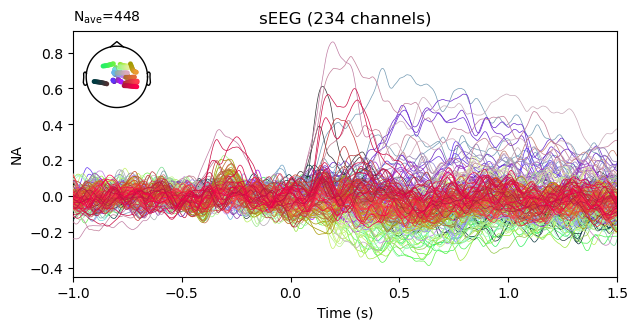

plotted
about to save
saved
Shape of HG_ev1._data: (448, 234, 2561)
Shape of HG_base._data: (448, 234, 1025)
Shape of sig1: (448, 234, 2561)
Shape of sig2: (448, 234, 1025)
Shape of sig3: (448, 234, 1026)
Shape of sig4: (448, 234, 1025)
Shape of sig5: (448, 234, 2561)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   59.5s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   59.6s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   59.6s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   59.6s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   59.7s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   59.8s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:  2.9min
[Parallel(

Saved channel names and indices to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0063\channels_D0063_GlobalLocal.txt
Saved significant channels for subject D0063 and mask Stimulus_fixationCrossBase_1sec_mirror to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0063\sig_chans_D0063_Stimulus_fixationCrossBase_1sec_mirror.json
Loaded significant channels for subject D0063


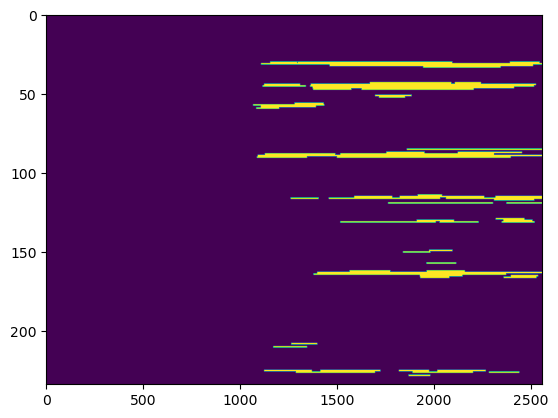

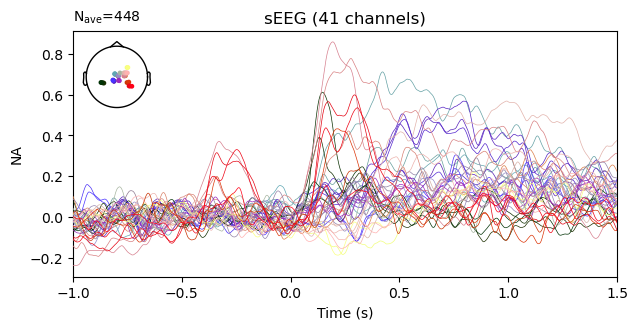

Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-01_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-01_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-01_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-02_desc-clean_ieeg.edf...
EDF file detected
Setting channel info str

C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (221) does not match the number of channels in the raw data file (220). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 217 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (221) does not match the number of channels in the raw data file (220). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 225 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (221) does not match the number of channels in the raw data file (220). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 222 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (221) does not match the number of channels in the raw data file (220). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


good channels before dropping bads: 220
filt channels before dropping bads: 220
outlier round 1 channels: ['RPIF3']
outlier round 1 channels: ['RPIF3', 'RAIO9']
outlier round 2 channels: ['RPIF3', 'RAIO9', 'RAMT15']
outlier round 2 channels: ['RPIF3', 'RAIO9', 'RAMT15', 'RMMT8']
Bad channels in 'good': ['RPIF3', 'RAIO9', 'RAMT15', 'RMMT8']
Bad channels in 'good' after dropping once: []
good channels after dropping bads: 216
filt channels after dropping bads: 216
Reading 0 ... 5705315  =      0.000 ...  2785.798 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s2

100%|██████████| 448/448 [08:00<00:00,  1.07s/it]


Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n25', 'Stimulus/c25/n75', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/n25', 'Stimulus/i75/n75', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75', 'experimentStart']
Not setting metadata
448 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 448 even

C:\Users\jz421\AppData\Local\Temp\ipykernel_15532\316368277.py:101: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_trials = mne.concatenate_epochs(all_epochs_list)


Not setting metadata
448 matching events found
No baseline correction applied


100%|██████████| 448/448 [11:08<00:00,  1.49s/it]


HG_ev1 before crop_pad:  -1.5 2.0
HG_ev1 after crop_pad:  -1.0 1.5
Applying baseline correction (mode: zscore)


C:\Users\jz421\AppData\Local\Temp\ipykernel_15532\316368277.py:111: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_base.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_15532\316368277.py:112: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_ev1.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_15532\316368277.py:114: RuntimeWarning: Mean of empty slice
  HG_ev1_avgOverTime = np.nanmean(HG_ev1.get_data(), axis=2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_15532\316368277.py:115: RuntimeWarning: Mean of empty slice
  HG_ev1_rescaled_avgOverTime = np.nanmean(HG_ev1_rescaled.get_data(), axis=2)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
plotting stimulus


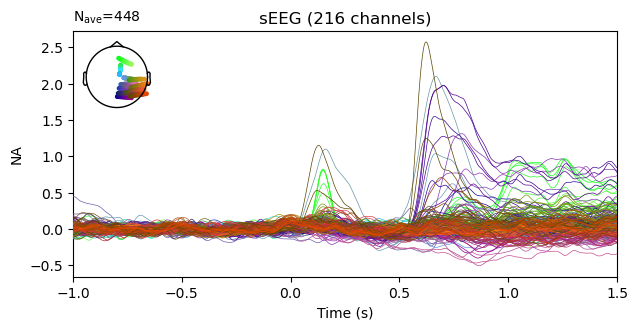

plotted
about to save
saved
Shape of HG_ev1._data: (448, 216, 2561)
Shape of HG_base._data: (448, 216, 1025)
Shape of sig1: (448, 216, 2561)
Shape of sig2: (448, 216, 1025)
Shape of sig3: (448, 216, 1026)
Shape of sig4: (448, 216, 1025)
Shape of sig5: (448, 216, 2561)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   56.5s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   57.2s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   57.4s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   57.5s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   57.7s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   57.8s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:  2.8min
[Parallel(

Saved channel names and indices to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0065\channels_D0065_GlobalLocal.txt
Saved significant channels for subject D0065 and mask Stimulus_fixationCrossBase_1sec_mirror to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0065\sig_chans_D0065_Stimulus_fixationCrossBase_1sec_mirror.json
Loaded significant channels for subject D0065


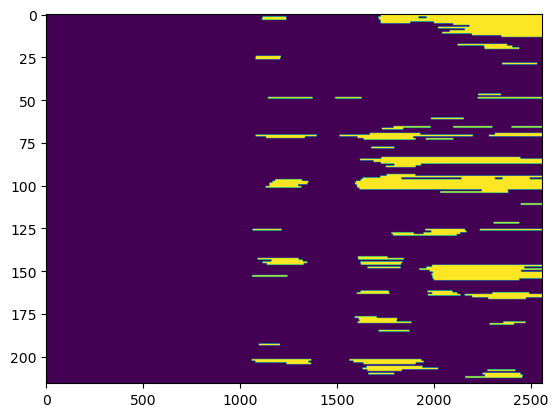

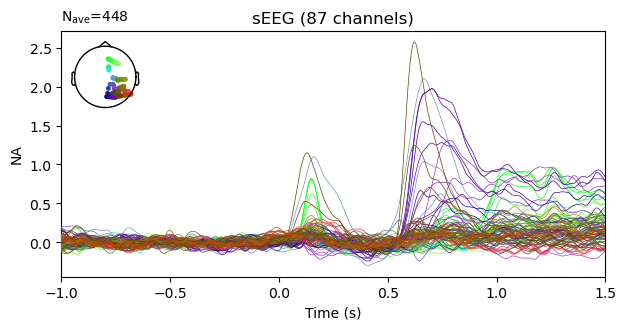

Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-01_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-01_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-01_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-02_desc-clean_ieeg.edf...
EDF file detected
Setting channel info str

C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (133) does not match the number of channels in the raw data file (132). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 224 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (133) does not match the number of channels in the raw data file (132). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 224 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (133) does not match the number of channels in the raw data file (132). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 214 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (133) does not match the number of channels in the raw data file (132). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


good channels before dropping bads: 132
filt channels before dropping bads: 132
outlier round 1 channels: ['LTMS11']
outlier round 2 channels: ['LTMS11', 'LTAS9']
Bad channels in 'good': ['LTMS11', 'LTAS9']
Bad channels in 'good' after dropping once: []
good channels after dropping bads: 130
filt channels after dropping bads: 130
Reading 0 ... 5221780  =      0.000 ...  2549.697 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/n25', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n75', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c

100%|██████████| 448/448 [04:28<00:00,  1.67it/s]


Used Annotations descriptions: ['Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/n25', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n75', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/n25', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/n25', 'Stimulus/i75/n75', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75', 'experimentStart']
Not setting metadata
448 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 448 even

C:\Users\jz421\AppData\Local\Temp\ipykernel_15532\316368277.py:101: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_trials = mne.concatenate_epochs(all_epochs_list)


Not setting metadata
448 matching events found
No baseline correction applied


100%|██████████| 448/448 [06:30<00:00,  1.15it/s]


HG_ev1 before crop_pad:  -1.5 2.0
HG_ev1 after crop_pad:  -1.0 1.5
Applying baseline correction (mode: zscore)


C:\Users\jz421\AppData\Local\Temp\ipykernel_15532\316368277.py:111: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_base.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_15532\316368277.py:112: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_ev1.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_15532\316368277.py:114: RuntimeWarning: Mean of empty slice
  HG_ev1_avgOverTime = np.nanmean(HG_ev1.get_data(), axis=2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_15532\316368277.py:115: RuntimeWarning: Mean of empty slice
  HG_ev1_rescaled_avgOverTime = np.nanmean(HG_ev1_rescaled.get_data(), axis=2)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
plotting stimulus


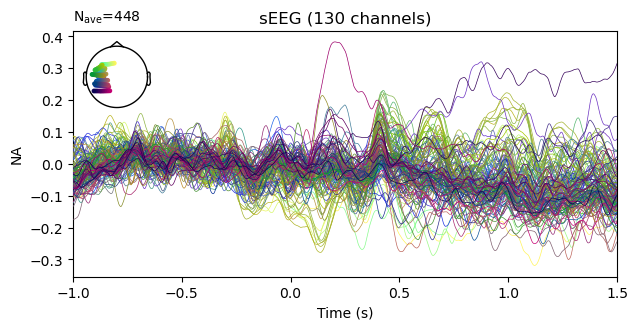

plotted
about to save
saved
Shape of HG_ev1._data: (448, 130, 2561)
Shape of HG_base._data: (448, 130, 1025)
Shape of sig1: (448, 130, 2561)
Shape of sig2: (448, 130, 1025)
Shape of sig3: (448, 130, 1026)
Shape of sig4: (448, 130, 1025)
Shape of sig5: (448, 130, 2561)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   56.0s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   56.0s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   56.2s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   56.3s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   56.4s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   56.5s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:  2.7min
[Parallel(

Saved channel names and indices to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0069\channels_D0069_GlobalLocal.txt
Saved significant channels for subject D0069 and mask Stimulus_fixationCrossBase_1sec_mirror to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0069\sig_chans_D0069_Stimulus_fixationCrossBase_1sec_mirror.json
Loaded significant channels for subject D0069


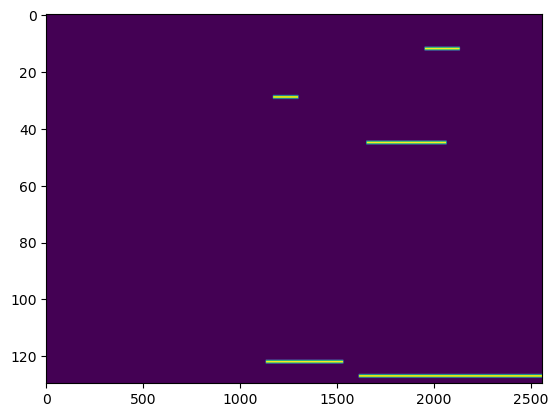

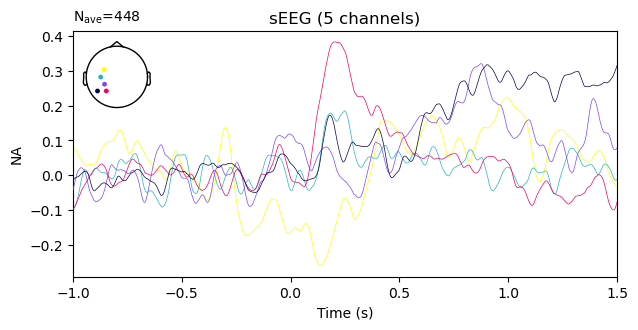

Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-01_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-01_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-01_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-02_desc-clean_ieeg.edf...
EDF file detected
Setting channel info str

C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (163) does not match the number of channels in the raw data file (162). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (163) does not match the number of channels in the raw data file (162). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (163) does not match the number of channels in the raw data file (162). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 225 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (163) does not match the number of channels in the raw data file (162). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


good channels before dropping bads: 162
filt channels before dropping bads: 162
outlier round 1 channels: ['RTAS7']
outlier round 1 channels: ['RTAS7', 'RTMM15']
outlier round 2 channels: ['RTAS7', 'RTMM15', 'RFO15']
outlier round 2 channels: ['RTAS7', 'RTMM15', 'RFO15', 'RTAS8']
outlier round 2 channels: ['RTAS7', 'RTMM15', 'RFO15', 'RTAS8', 'RTMM16']
Bad channels in 'good': ['RTAS7', 'RTMM15', 'RFO15', 'RTAS8', 'RTMM16']
Bad channels in 'good' after dropping once: []
good channels after dropping bads: 157
filt channels after dropping bads: 157
Reading 0 ... 4864645  =      0.000 ...  2375.315 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/n25', 'Response/c75/n75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i

100%|██████████| 448/448 [05:29<00:00,  1.36it/s]


Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/n25', 'Response/c75/n75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n25', 'Stimulus/c25/n75', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/n25', 'Stimulus/c75/n75', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75', 'experimentStart']
Not setting metadata
448 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 448 even

C:\Users\jz421\AppData\Local\Temp\ipykernel_15532\316368277.py:101: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_trials = mne.concatenate_epochs(all_epochs_list)


Not setting metadata
448 matching events found
No baseline correction applied


100%|██████████| 448/448 [08:18<00:00,  1.11s/it]


HG_ev1 before crop_pad:  -1.5 2.0
HG_ev1 after crop_pad:  -1.0 1.5
Applying baseline correction (mode: zscore)


C:\Users\jz421\AppData\Local\Temp\ipykernel_15532\316368277.py:111: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_base.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_15532\316368277.py:112: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_ev1.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_15532\316368277.py:114: RuntimeWarning: Mean of empty slice
  HG_ev1_avgOverTime = np.nanmean(HG_ev1.get_data(), axis=2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_15532\316368277.py:115: RuntimeWarning: Mean of empty slice
  HG_ev1_rescaled_avgOverTime = np.nanmean(HG_ev1_rescaled.get_data(), axis=2)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
plotting stimulus


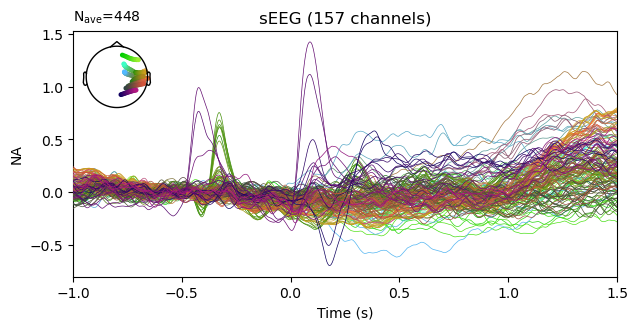

plotted
about to save
saved
Shape of HG_ev1._data: (448, 157, 2561)
Shape of HG_base._data: (448, 157, 1025)
Shape of sig1: (448, 157, 2561)
Shape of sig2: (448, 157, 1025)
Shape of sig3: (448, 157, 1026)
Shape of sig4: (448, 157, 1025)
Shape of sig5: (448, 157, 2561)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   56.2s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   56.3s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   56.3s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   56.4s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   56.7s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   56.7s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:  2.7min
[Parallel(

Saved channel names and indices to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0071\channels_D0071_GlobalLocal.txt
Saved significant channels for subject D0071 and mask Stimulus_fixationCrossBase_1sec_mirror to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0071\sig_chans_D0071_Stimulus_fixationCrossBase_1sec_mirror.json
Loaded significant channels for subject D0071


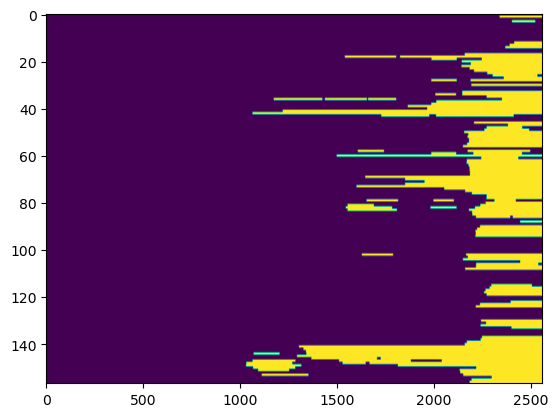

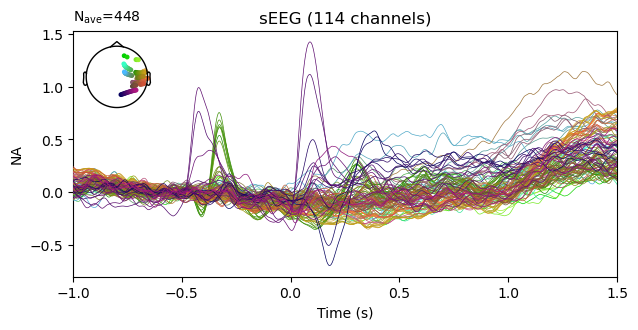

In [38]:
import sys
print(sys.path)
sys.path.append("C:/Users/jz421/Desktop/GlobalLocal/IEEG_Pipelines/") #need to do this cuz otherwise ieeg isn't added to path...

from ieeg.navigate import channel_outlier_marker, trial_ieeg, crop_empty_data, \
    outliers_to_nan
from ieeg.io import raw_from_layout, get_data
from ieeg.timefreq.utils import crop_pad
from ieeg.timefreq import gamma
from ieeg.calc.scaling import rescale
import mne
import os
import numpy as np
from ieeg.calc.reshape import make_data_same
from ieeg.calc.stats import time_perm_cluster

from misc_functions import calculate_RTs, save_channels_to_file, save_sig_chans, load_sig_chans
import matplotlib.pyplot as plt

subjects = ['D0059', 'D0063', 'D0065', 'D0069', 'D0071']

for sub in subjects:
    # sub = 'D0057'
    task = 'GlobalLocal'
    output_name = "Stimulus_fixationCrossBase_1sec_mirror"
    events = ["Stimulus"]
    times = (-1,1.5)
    base_times = [-1,0]
    LAB_root = None
    channels = None
    full_trial_base = False

    if LAB_root is None:
        HOME = os.path.expanduser("~")
        if os.name == 'nt':  # windows
            LAB_root = os.path.join(HOME, "Box", "CoganLab")
        else:  # mac
            LAB_root = os.path.join(HOME, "Library", "CloudStorage", "Box-Box",
                                    "CoganLab")

    layout = get_data(task, root=LAB_root)
    filt = raw_from_layout(layout.derivatives['derivatives/clean'], subject=sub,
                        extension='.edf', desc='clean', preload=False)
    save_dir = os.path.join(layout.root, 'derivatives', 'freqFilt', 'figs', sub)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    good = crop_empty_data(filt)
    # %%

    print(f"good channels before dropping bads: {len(good.ch_names)}")
    print(f"filt channels before dropping bads: {len(filt.ch_names)}")

    good.info['bads'] = channel_outlier_marker(good, 3, 2)
    print("Bad channels in 'good':", good.info['bads'])

    filt.drop_channels(good.info['bads'])  # this has to come first cuz if you drop from good first, then good.info['bads'] is just empty
    good.drop_channels(good.info['bads'])

    print("Bad channels in 'good' after dropping once:", good.info['bads'])

    print(f"good channels after dropping bads: {len(good.ch_names)}")
    print(f"filt channels after dropping bads: {len(filt.ch_names)}")

    good.load_data()

    # If channels is None, use all channels
    if channels is None:
        channels = good.ch_names
    else:
        # Validate the provided channels
        invalid_channels = [ch for ch in channels if ch not in good.ch_names]
        if invalid_channels:
            raise ValueError(
                f"The following channels are not valid: {invalid_channels}")

        # Use only the specified channels
        good.pick_channels(channels)

    ch_type = filt.get_channel_types(only_data_chs=True)[0]
    good.set_eeg_reference(ref_channels="average", ch_type=ch_type)

    # Create a baseline EpochsTFR using the stimulus event

    adjusted_base_times = [base_times[0] - 0.5, base_times[1] + 0.5]
    trials = trial_ieeg(good, "Stimulus", adjusted_base_times, preload=True)
    outliers_to_nan(trials, outliers=10)
    HG_base = gamma.extract(trials, copy=False, n_jobs=1)
    crop_pad(HG_base, "0.5s")

    all_epochs_list = []

    for event in events:
    # Epoching and HG extraction for each specified event. Then concatenate all trials epochs objects together (do Stimulus/c25 and Stimulus/c75 for example, and combine to get all congruent trials)
        times_adj = [times[0] - 0.5, times[1] + 0.5]
        trials = trial_ieeg(good, event, times_adj, preload=True,
                            reject_by_annotation=False)
        all_epochs_list.append(trials)

    # Concatenate all trials
    all_trials = mne.concatenate_epochs(all_epochs_list)

    outliers_to_nan(all_trials, outliers=10)
    HG_ev1 = gamma.extract(all_trials, copy=True, n_jobs=1)
    print("HG_ev1 before crop_pad: ", HG_ev1.tmin, HG_ev1.tmax)
    crop_pad(HG_ev1, "0.5s")
    print("HG_ev1 after crop_pad: ", HG_ev1.tmin, HG_ev1.tmax)

    HG_ev1_rescaled = rescale(HG_ev1, HG_base, copy=True, mode='zscore')

    HG_base.decimate(2)
    HG_ev1.decimate(2)

    HG_ev1_avgOverTime = np.nanmean(HG_ev1.get_data(), axis=2)
    HG_ev1_rescaled_avgOverTime = np.nanmean(HG_ev1_rescaled.get_data(), axis=2)

    HG_ev1_evoke = HG_ev1.average(method=lambda x: np.nanmean(x, axis=0)) #axis=0 should be set for actually running this, the axis=2 is just for drift testing.
    HG_ev1_evoke_rescaled = HG_ev1_rescaled.average(method=lambda x: np.nanmean(x, axis=0))

    if event == "Stimulus":
        print('plotting stimulus')
        fig = HG_ev1_evoke_rescaled.plot(unit=False, scalings=dict(sEEG=1)) #this line is not finishing...
        print('plotted')
        # for ax in fig.axes:
        #     ax.axvline(x=avg_RT, color='r', linestyle='--')
        print('about to save')
        fig.savefig(save_dir + '_HG_ev1_Stimulus_zscore.png')
        print('saved')
    else:
        print('about to plot if not stimulus')
        fig = HG_ev1_evoke_rescaled.plot(unit=False, scalings=dict(sEEG=1))
        print('plotted non stimulus')
        fig.savefig(save_dir + f'_HG_ev1_{output_name}_zscore.png')

    ###
    print(f"Shape of HG_ev1._data: {HG_ev1._data.shape}")
    print(f"Shape of HG_base._data: {HG_base._data.shape}")

    sig1 = HG_ev1._data
    sig2 = HG_base._data
    sig3 = make_data_same(sig2, (sig2.shape[0],sig2.shape[1],sig2.shape[2]+1)) # originally we want to make the baseline the same shape as the signal. We still want to do that, but first, we'll make it bigger to reflect it once, then back to normal to randomly offset it and remove fixation cross effects.
    sig4 = make_data_same(sig3, sig2.shape) #here we do the random offset, we know that sig3 is bigger than sig1 by 1 in the time dimension so it will get randomly sliced.
    sig5 = make_data_same(sig4, sig1.shape) #and now sig4 should be sig2 but with a random offset, and we can then set it equal to sig1's shape like the original plan.
    print(f"Shape of sig1: {sig1.shape}")
    print(f"Shape of sig2: {sig2.shape}")
    print(f"Shape of sig3: {sig3.shape}")
    print(f"Shape of sig4: {sig4.shape}")
    print(f"Shape of sig5: {sig5.shape}")

    sig2 = sig5

    mat = time_perm_cluster(sig1, sig2, 0.05, n_jobs=6, ignore_adjacency=1)
    fig = plt.figure()
    plt.imshow(mat, aspect='auto')
    fig.savefig(save_dir + f'_{output_name}_stats.png', dpi=300)

    channels = good.ch_names

    #save channels with their indices 
    save_channels_to_file(channels, sub, task, save_dir)

    # save significant channels to a json
    save_sig_chans(f'{output_name}', mat, channels, sub, save_dir)


    base_path = r'C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs'
    stim_filename = f'{base_path}\\{sub}\\sig_chans_{sub}_Stimulus_fixationCrossBase_1sec_mirror.json'
    stim_sig_chans = load_sig_chans(stim_filename)

    fig = HG_ev1_evoke_rescaled.plot(unit=False, scalings=dict(sEEG=1), picks=stim_sig_chans) #this line is not finishing...

    fig.savefig(save_dir + '_HG_ev1_Stimulus_fixationCrossBase_1sec_mirror_zscore_sigChans.png')

### ok make greg significance and high gamma combined plots

In [7]:
from PIL import Image, ImageChops

def trim_whitespace(image):
    """
    Trims the whitespace from an image.
    """
    bg = Image.new(image.mode, image.size, image.getpixel((0, 0)))
    diff = ImageChops.difference(image, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return image.crop(bbox)
    return image  # If no change

channel_to_index = {}

with open('channels_D0057_GlobalLocal.txt', 'r') as f: #can probably just send the filepath here instead of uploading the text file to here but do that later lol.
    for line in f:
        index, channel = line.strip().split(': ')
        channel_to_index[channel] = int(index)


### new code that tries to plot 6x6 grid of 36 channels on one plot

In [13]:
# Assuming all imports and previous definitions are in place

def plot_channels_on_grid(channels_subset):
    fig, axes = plt.subplots(6, 6, figsize=(20, 20))
    fig.suptitle("Channels with Significance Overlay")
    axes_flat = axes.flatten()

    for channel, ax in zip(channels_subset, axes_flat):
        time_in_seconds = np.arange(0, len(mat[channel_to_index[channel]])) / 1000  # Assuming 1kHz sample rate
        sig_data_in_seconds = np.array(mat[channel_to_index[channel]])
        ax.plot(HG_ev1_evoke_rescaled.times, HG_ev1_evoke_rescaled.data[channel_to_index[channel], :])

        # Find the maximum y-value for the current channel
        max_y_value = np.max(HG_ev1_evoke_rescaled.data[channel_to_index[channel], :])

        # Overlay significance as a horizontal line at the max y-value
        significant_points = np.where(sig_data_in_seconds == 1)[0]
        for point in significant_points:
            ax.hlines(y=max_y_value, xmin=time_in_seconds[point]-1, xmax=time_in_seconds[point] + 0.005 - 1, color='red', linewidth=0.5) # subtract 1 cuz the sig time is from 0 to 2.5, while the high gamma time is from -1 to 1.5

        ax.set_title(channel)

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    return fig

# Iterate over all channels in chunks of 36 and plot them
for i in range(0, len(stim_sig_chans), 36):
    channels_subset = stim_sig_chans[i:i+36]
    fig = plot_channels_on_grid(channels_subset)
    combined_plot_path = os.path.join(save_dir, f'combinedChannelTracesAndSignificance_Page_{i//36 + 1}.png')
    fig.savefig(combined_plot_path)
    plt.close(fig)
